# Transfer Learning from Inception Model - with Keras
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
In the previous notebook we have seen how long it takes to process a CNN for image recognition, even using $TensorFlow$, that is efficient enough compared to other tools, and very small pictures. Also the results are good for the dataset we've used, but not outstanding. 
The advantage of using Neural Networks in general is that, even if it takes long to train, the Network itself can be loaded and used offline with not much effort. The intuition here is to use a pre-trained CNN and transfer part of it to build a new classifier (in this case based on CIFAR-10 to make a comparison). 

This time we will define the model using **Keras** and run everything on GPU instead of CPU.

## Inception Model
The Inception v3 model is a CNN by Google that takes weeks to train on a computer with 8 Tesla K40 GPUs and is impossible to train it on an ordinary PC. We will instead download the pre-trained Inception model and use it to classify images and then as a base to build the CIFAR-10 classifier we've seen in the previous notebook to then compare results. The advantages of Neural Networks are pretty much clear in this model that takes ages to train on a regular PC, but only a moment to use. 
The following picture shows the architecture of the model.

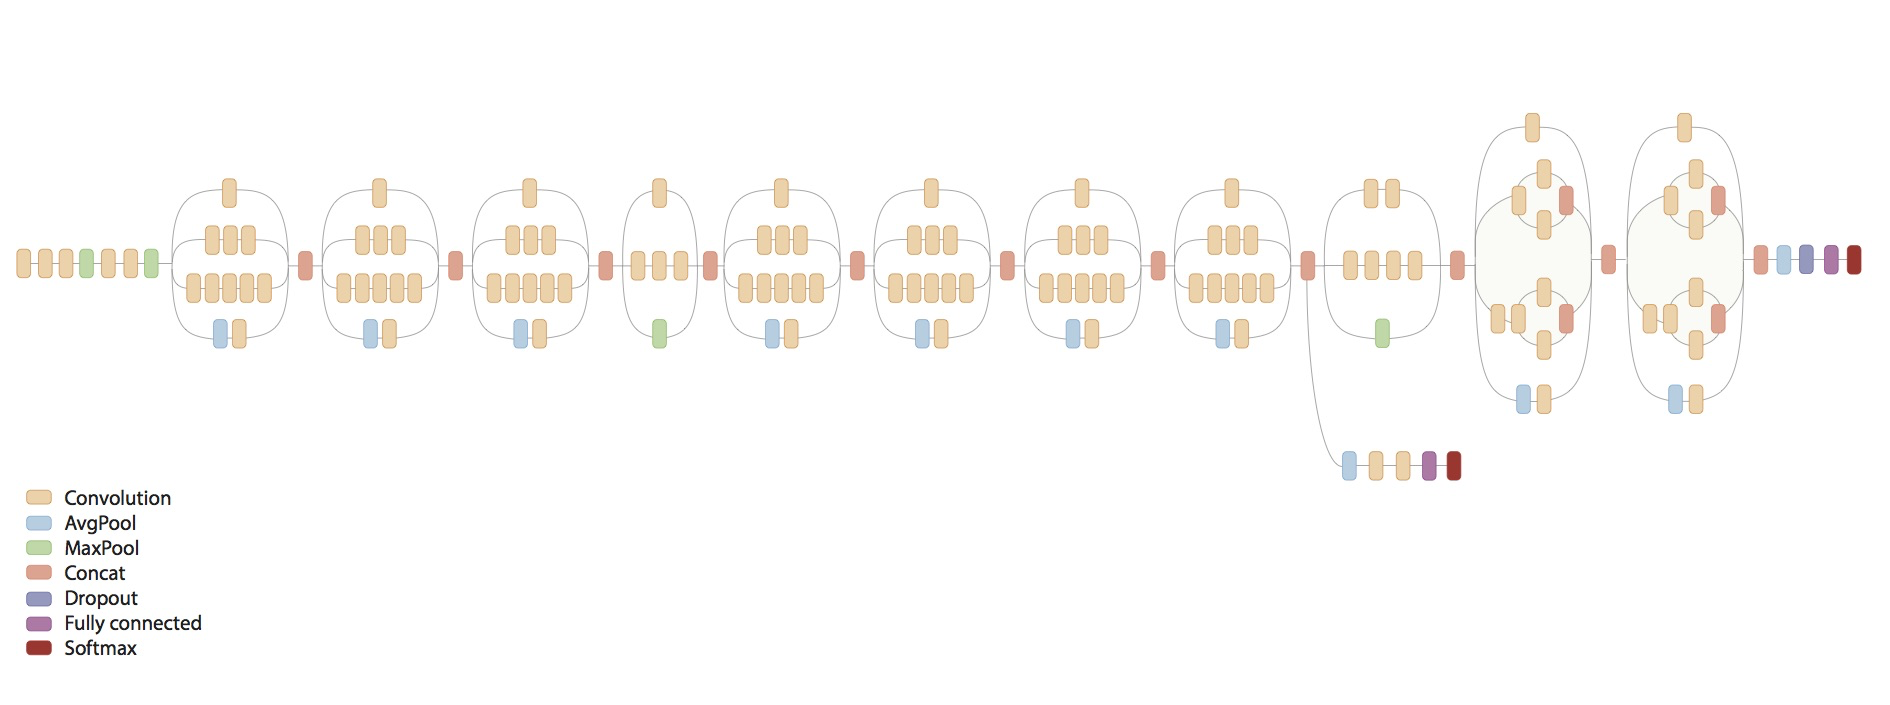

In [1]:
from IPython.display import Image, display
Image('../images/04_inceptionV3Architecture.png')

The chart shows that Inception V3 is a Convolutional Neural Network with many layers and a very complicated structure. The two softmax layers are used during training and only the left one is used for classification. This is done in order to fight the vanishing gradient problem in very deep networks, a problem that we've partially experienced in the last notebook (the second convolutional layer had a much lower standard deviation compared to the first one). To avoid overfitting they use a regularization parameter, and they also admit in the research paper that they don't fully understand why Inception V3 works, but it actually outperforms every state of the art model before its release, and by a substantial margin.

It is trained using **ImageNet**, a common academic data set in machine learning for training an image recognition system, but with much higher resolution image compared to CIFAR-10, so it would require a lot of time to train. 

## Imports

In [2]:
%matplotlib inline
import tensorflow as tf

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  
import os
from IPython.display import Image

from util import Util
u = Util()
from util_transfer import UtilTransfer
ut = UtilTransfer()

# Functions and classes for loading and using the Inception model.
import inception

tf.__version__

'0.12.1'

Now that the library is imported we can load the data from the CNN.

In [3]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Image classification with Inception V3
The download of the Inception model also includes an example image, and a very low resolution one, to test if everything worked fine. We're going to use it to provide an example of classification.

In [4]:
# Load the Inception model so it is ready for classifying images.
inception_model = inception.Inception()
# Helper-function for classifying and plotting images
def classify(image_path):
    display(Image(image_path))
    pred = inception_model.classify(image_path=image_path)
    inception_model.print_scores(pred=pred, k=10, only_first_name=True)
# Image path for the example picture to classify
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')

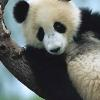

89.23% : giant panda
 0.86% : indri
 0.26% : lesser panda
 0.14% : custard apple
 0.11% : earthstar
 0.08% : sea urchin
 0.05% : forklift
 0.05% : soccer ball
 0.05% : go-kart
 0.05% : digital watch


In [5]:
classify(image_path)

## Transfer Learning
The goal is to re-use the pre-trained Inception model and replace the layer that does the final classification. This is called **Transfer Learning**, since we're not training the CNN from scratch or random values, but from a previous training, at least of the convolutional part. We're still going to train our classifier, but starting from features extracted by a very capable network. 

The goal is to produce a CNN that takes less time to train and is more accurate than the previous one, using the same CIFAR-10 dataset. 

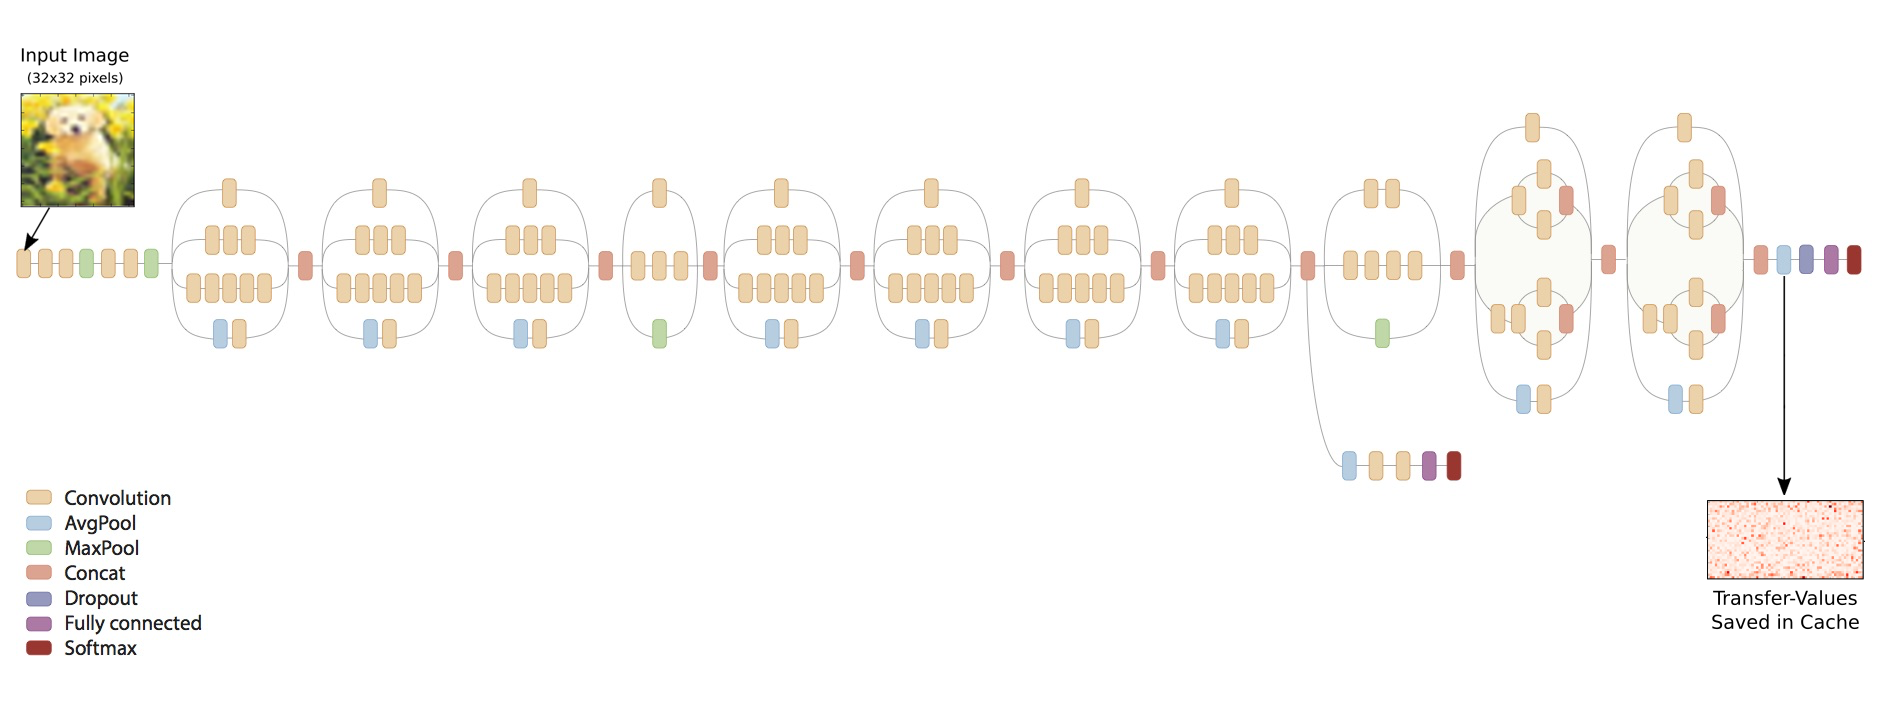

In [6]:
Image('../images/04_architecture_1.png')

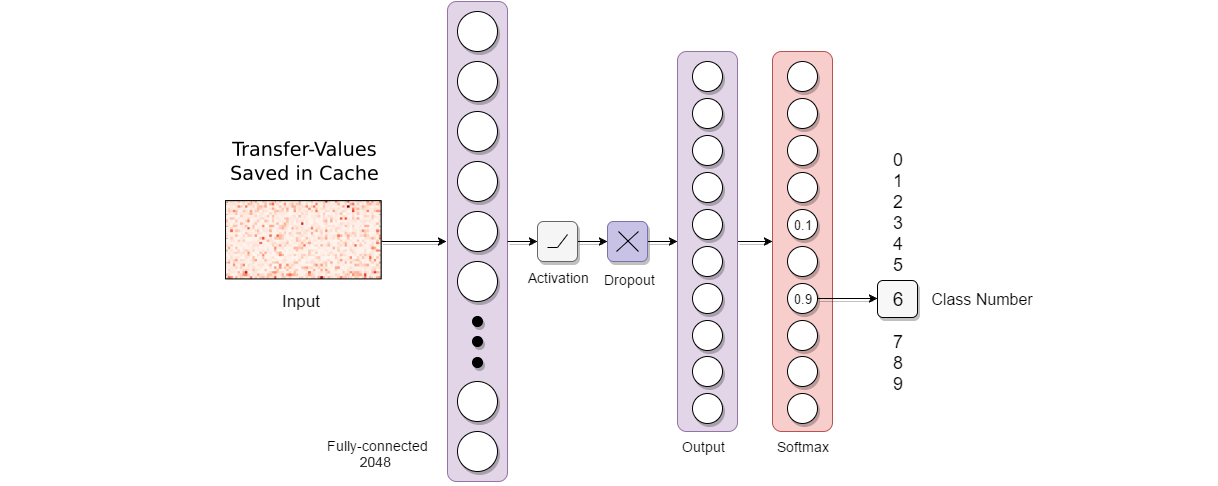

In [33]:
Image('images/05_architecture_2.png')

As the flowcharts show, we process images from the new data-set with the Inception model. Before the final classification layer, we save the **Transfer-Values** to a cache-file. This saves a lot of time of computation for extracting features from the new data-set.
Those Transfer-Values are then used as the input to a second neural network, which will be trained with the classes of the new data-set.
This means that the final classification will be based on the Trasfer-Values obtained from the Inception model.

## Imports

In [8]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


## Definitions

In [9]:
batch_size = 512
nb_classes = 10
nb_epoch = 200
# checkpoint path
checkpoints_filepath = "checkpoints/transfer_learning_keras_weights.best.hdf5"

In [10]:
# dense layer size
dense_layer_size1 = 2048

## Load Data for CIFAR-10

We load data from CIFAR-10 and set the path.

In [11]:
import cifar10
from cifar10 import num_classes
# cifar10.data_path = "data/CIFAR-10/"

cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


We now load the class-names.

In [12]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

We now load the training set and test set.

In [13]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Size of:
- Training-set:		50000
- Test-set:		10000


### Helper-function for plotting images


In [14]:
def plot_images(images, cls_true, cls_pred=None, smooth=True): 
    u.plot_images_2(images=images, cls_true=cls_true, class_names=class_names, cls_pred=cls_pred, smooth=smooth)

### Plot a few images to test

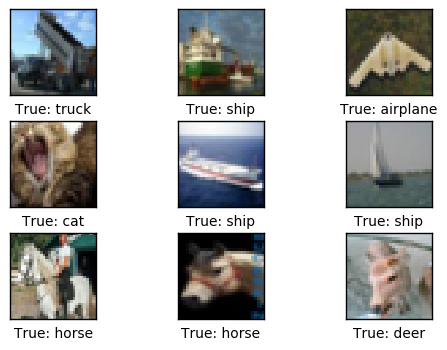

In [15]:
# Get the first images from the test-set.
images = images_test[50:59]

# Get the true classes for those images.
cls_true = cls_test[50:59]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

### Download and Load the Inception Model

In [16]:
# inception.data_dir = 'inception/'
cache_dir = "cache/"
inception.maybe_download()

inception_model = inception.Inception()

Data has apparently already been downloaded and unpacked.


## Calculate Transfer-Values
We import a helper-function for caching the transfer-values of the Inception model.

Since CIFAR returns pixels between 0 and 1, while Inception model needs pixel colors to be scaled between 0 and 255, we need to multiply them. We are doing it for both training and test sets.

In [17]:
from inception import transfer_values_cache

file_path_cache_train = os.path.join(cache_dir, 'inception_cifar10_train.pkl')
file_path_cache_test = os.path.join(cache_dir, 'inception_cifar10_test.pkl')

images_scaled = images_train * 255.0

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=inception_model)

images_scaled = images_test * 255.0

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=inception_model)

- Data loaded from cache-file: cache/inception_cifar10_train.pkl
- Data loaded from cache-file: cache/inception_cifar10_test.pkl


In [18]:
transfer_values_train.shape

(50000, 2048)

In [19]:
transfer_values_test.shape

(10000, 2048)

### Helper-function for plotting Transfer-Values

In [20]:
def plot_transfer_values(i): 
    u.plot_transfer_values(i=i, images=images_test, transfer_values=transfer_values_test)

Input image:


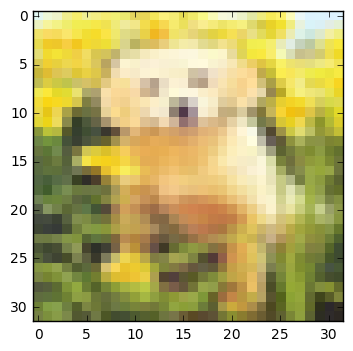

Transfer-values for the image using Inception model:


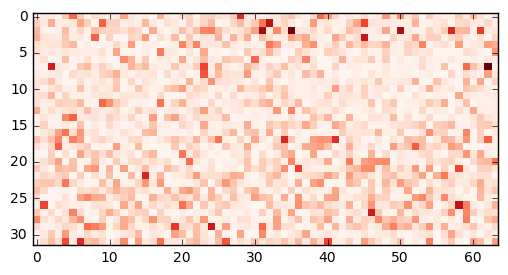

In [21]:
plot_transfer_values(190)

## Classification of Transfer-Values
We will now code a new classifier using $TensorFlow$ and **Keras** as in the previous notebook. This time the classifier has one less layer since we rely more on the pre-trained convolutional network, and doing so will save a lot of computation time. 

The new network, as said before, will take the transfer values as input (x) and then output the classes from the CIFAR-10 dataset. 

### Adapt input

In [22]:
transfer_len = inception_model.transfer_len

X_train = transfer_values_train.reshape(transfer_values_train.shape[0], transfer_values_train.shape[1])
X_test = transfer_values_test.reshape(transfer_values_test.shape[0], transfer_values_test.shape[1])

In [23]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 2048)
50000 train samples
10000 test samples


In [24]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(cls_train, nb_classes)
Y_test = np_utils.to_categorical(cls_test, nb_classes)

### Neural Network
Using **Keras** to describe it at a higher level.

In [25]:
def initialize_network_single_column(model, nb_classes, dense_layer_size1):
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons', 
                    input_shape=(2048, )))
    model.add(Activation('relu', name='activation_1_' + 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')
        
model = Sequential()
initialize_network_single_column(model, nb_classes, dense_layer_size1)
try_load_checkpoints(model, checkpoints_filepath)

## Results

In [26]:
# checkpoint
checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fits the model on clear training set, for nb_epoch-700 epochs
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test), 
                    callbacks=callbacks_list)

# ensuring best val_precision reached during training
model.load_weights(checkpoints_filepath)

Epoch 00000: val_acc improved from -inf to 0.85070, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00001: val_acc improved from 0.85070 to 0.87080, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00002: val_acc improved from 0.87080 to 0.88180, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00003: val_acc improved from 0.88180 to 0.88250, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00004: val_acc improved from 0.88250 to 0.89420, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc improved from 0.89420 to 0.89630, saving model to checkpoints/transfer_learning_keras_weights.best.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved f

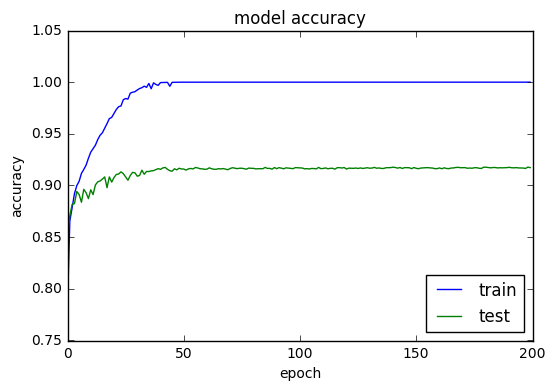

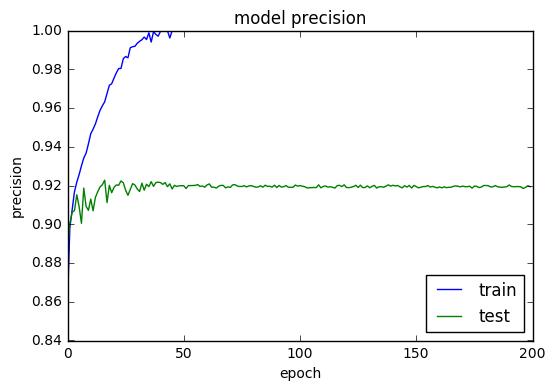

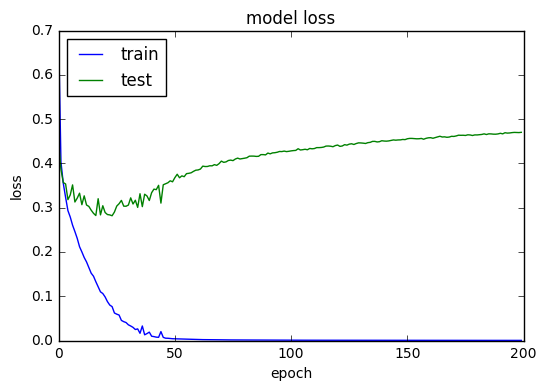

In [27]:
u.plot_history(history)
u.plot_history(history, 'precision')
u.plot_history(history, metric='loss', loc='upper left')

As we can see, after only 100 iterations the error on the training set was already pretty low. 

In [28]:
print('evaluating new model')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2]*100, '%')
print('Test error:', (1-score[2])*100, '%')

evaluating new model
Test score: 0.469494850995
Test accuracy: 0.9178
Test precision: 91.9918708038 %
Test error: 8.00812919617 %


In [29]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == Y_test.argmax(axis=1))[0]
incorrect_indices = np.nonzero(predicted_classes != Y_test.argmax(axis=1))[0]

 9920/10000 [============================>.] - ETA: 0s

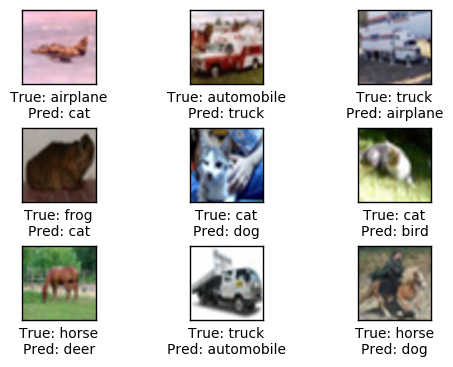

In [41]:
idx = np.random.choice(np.arange(len(incorrect_indices)), 9, replace=False)
u.plot_images_2(images_test[incorrect_indices[idx]], Y_test.argmax(axis=1)[incorrect_indices[idx]], 
                class_names, predicted_classes[incorrect_indices[idx]])

[922   8  11   7   4   0   1   2  34  11] (0) airplane
[  6 950   2   4   0   2   2   1   3  30] (1) automobile
[ 15   0 903  20  22   8  22   7   2   1] (2) bird
[  5   2  15 858  17  66  23  10   3   1] (3) cat
[  5   0  17  21 905   7  17  25   2   1] (4) deer
[  4   0   9  76  16 872   6  16   1   0] (5) dog
[  2   1  16  14  14   4 945   1   3   0] (6) frog
[  8   0   7  14  16  17   4 929   2   3] (7) horse
[ 26   5   0   2   0   2   3   0 958   4] (8) ship
[  9  35   3   2   0   0   1   1  13 936] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


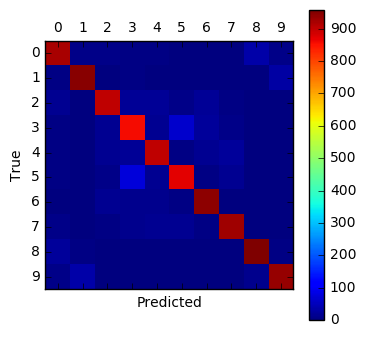

In [31]:
ut.plot_confusion_matrix(predicted_classes, Y_test.argmax(axis=1), num_classes, class_names)

As before, the NN finds difficult to discriminate between similar animals, probably because the pictures are very small, and the Transfer Values could extract similar features. However 92% is a good precision on CIFAR-10.

## Close Inception Model Session

In [32]:
inception_model.close()

## Performance
The computation of Transfer Values with GPU (about 1000 cuda cores) took about 1 hour, compared to the 3 hours it takes on CPU (the operation is sequential by images, so the GPU is not fully utilized).  

The training took even less time, about 5 minutes on GPU, performing just 200 epochs (optimization iterations on full batch, not random batches), while the previous CNN took 12 hours (on CPU) for 100000 iterations (on random batches). The NN is much smaller now, because we don't train any convolutional layer but we use the Transfer Values instead.

The accuracy is a nice 91.8%, with respect to the previous 80% without transfer learning and 90% with random batches (CPU, no Keras). 

It's worth mentioning that for this notebook the fully-connected layer has a size of 2048, so all the features extracted by Inception, double compared to our previous experiment. However even with 1024 features the accuracy was 91.7%. 

The world record for CIFAR-10 is 96.53% accuracy, but on a multi-column network that takes many hours to train and it's made for this particular dataset, also using the same training set expansion that we used previously. The human record is about 93.2% precision, pretty close to our 99.2% precision. 

## Conclusion
**Keras** is a very good library for $Tensorflow$, allowing easy model definition. What transpired more from the previous notebooks however it's how fast the library performs on a GPU compared to a CPU. The overall process took about 1 hour compared to the 3 hours on CPU, and that's just because the calculation of the transfer values is not optimized. 